In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('ggplot')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [64]:
df = pd.read_csv('Spotify.csv')
df['mood'] = df['happy'].apply(lambda x: (x and 'happy') or 'sad')
df = df.dropna()
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_names,artist_names,happy,genre,mood
0,0.813,0.640,2,-5.908,1,0.2720,0.2690,0.0000,0.1310,0.488,92.989,147076,4,Jolie nana,['Aya Nakamura'],1,Alternative,happy
1,0.729,0.788,10,-4.832,0,0.0908,0.0703,0.0000,0.1150,0.857,118.039,159536,4,Say My Name,"['Dimitri Vegas & Like Mike', 'Regard', 'Dimit...",1,house,happy
2,0.624,0.628,4,-6.582,0,0.0408,0.0112,0.0191,0.0814,0.772,114.556,147071,4,Let Me Move You - From the Netflix film Work It,['Sabrina Carpenter'],1,pop,happy
3,0.660,0.755,0,-4.501,0,0.0469,0.0876,0.0000,0.1020,0.862,145.948,156368,4,NIGHTRIDER,['Arizona Zervas'],1,pop,happy
4,0.789,0.711,2,-4.248,1,0.0410,0.0332,0.0000,0.0876,0.753,112.985,190306,4,Take You Dancing,['Jason Derulo'],1,pop,happy


In [65]:
X = df.loc[:,['danceability', 'energy', 'key', 
                      'loudness', 'mode', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 
                      'valence','duration_ms','tempo']]

y = df['genre']

In [66]:
df.genre.unique()

array(['Alternative', 'house', 'pop', 'r&b', 'rock', 'country', 'hip hop',
       'jazz', 'latin', 'classical'], dtype=object)

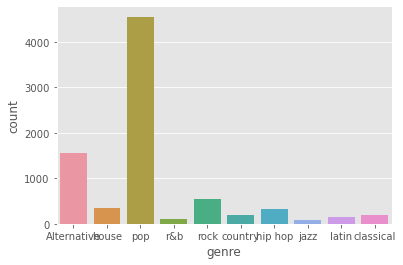

In [76]:
sns.countplot(x=df['genre'])

Working with an imbalanced dataset

In [77]:
def model_pipeline(X,y):
    '''
   Function to streamline model selection
    
    '''
    # 80:20 split holding out test set. Calling kfold because i have a small sample size
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

    classifiers = [OneVsRestClassifier(LogisticRegression()),OneVsRestClassifier(RandomForestClassifier()), OneVsRestClassifier(XGBClassifier(n_jobs=-1,max_depth=4)), OneVsRestClassifier(AdaBoostClassifier(n_estimators = 100, random_state=0))]
    class_label = ['Logistic Regression','Random Forest','XGBoost','Adaboost']
    columns = ['Classifier','Accuracy','F1-Score']

    clf_df = pd.DataFrame(index=[0],columns=columns)
    fig = plt.figure(figsize=(12,4))

    for clf in classifiers:
    
        # FIT CLASSIFIER
        clf.fit(X_train,y_train)

        # PREDICT ON TEST SET
        y_pred = clf.predict(X_test)

        # ACCURACY SCORE
        acc = accuracy_score(y_test, y_pred)
        
        # F1 SCORE
        f1 = f1_score(y_test, y_pred, average = 'micro')

        # PROBABILITIES
        y_pred_prob = clf.predict_proba(X_test)[:,1]

        # ADD SCORES TO DF
        clf_df.loc[classifiers.index(clf)] = [class_label[classifiers.index(clf)],
                                              '{:.2%}'.format(acc),'{:.2%}'.format(f1)]

    plt.tight_layout()
    clf_df = clf_df.set_index('Classifier')
    print(clf_df)
    plt.show()


In [78]:
model_pipeline(X,y)

                    Accuracy F1-Score
Classifier                           
Logistic Regression   56.97%   56.97%
Random Forest         66.77%   66.77%
XGBoost               64.60%   64.60%
Adaboost              63.86%   63.86%


<Figure size 864x288 with 0 Axes>

Looks like I'll go with another random forest again for my final model

# Hypertuning Final Model Parameters (Random Forest)

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': np.arange(10,200,10),
              'min_samples_leaf': np.arange(1,100,10),
              'max_features': ['auto', 'sqrt', 'log2']}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

print(rf_cv.best_params_)
print(rf_cv.best_score_)

ne=rf_cv.best_params_['n_estimators']
msl=rf_cv.best_params_['min_samples_leaf']
mf=rf_cv.best_params_['max_features']

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}
0.6477371357718537


In [96]:
# Create the classifier
final_model = RandomForestClassifier(n_estimators=ne,
                            min_samples_leaf=msl,
                            max_features=mf)

# Fit the classifier to the training data
final_model.fit(X, y)

# Predict on the test set
y_pred_final_model = final_model.predict(X)

# PREDICTION PROBABILITIES
y_pred_prob_final_model = final_model.predict_proba(X)[:,1]

In [97]:
#print('ROC AUC Score:','{:.2%}'.format(roc_auc_score(y, y_pred_prob_final_model, average = 'micro')))
print('Test Accuracy:', '{:.2%}'.format(accuracy_score(y, y_pred_final_model)))
print('Precision:','{:.2%}'.format(precision_score(y, y_pred_final_model, average = 'micro')))
print('Recall:', '{:.2%}'.format(recall_score(y, y_pred_final_model, average = 'micro')))

#print('Recall:', recall_score(y_test,rf.predict(X_test))

#print('\n Clasification Report:\n', classification_report(y, y_pred_final_model))

Test Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%


In [98]:
names = df.columns
print(sorted(zip(map(lambda x: round(x, 4), final_model.feature_importances_), names), 
             reverse=True))

[(0.1154, 'tempo'), (0.1097, 'loudness'), (0.1081, 'instrumentalness'), (0.0908, 'energy'), (0.09, 'speechiness'), (0.0894, 'valence'), (0.0886, 'danceability'), (0.0869, 'acousticness'), (0.0853, 'duration_ms'), (0.0751, 'liveness'), (0.0476, 'key'), (0.0132, 'mode')]
